<a href="https://colab.research.google.com/github/svsamsonov/ex2mcmc_new/blob/master/colab_notebooks/flex2mcmc_sngan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ex2mcmc
!pip install git+https://github.com/kwotsin/mimicry.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.2/709.2 kB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 kB 44.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/kwotsin/mimicry.git to /tmp/pip-req-build-3mv87__m
  Running command git clone --filter=blob:none --quiet https://github.com/kwotsin/mimicry.git /tmp/pip-req-build-3mv87__m
  Resolved https://github.com/kwotsin/mimicry.git to commit a7fda06c4aff1e6af8dc4c4a35ed6636e434c766
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.

In [ ]:
!git clone https://github.com/svsamsonov/ex2mcmc_new

In [ ]:
!ln -s /content/ex2mcmc_new/configs/ .

ln: failed to create symbolic link './configs': File exists


In [ ]:
%load_ext autoreload
%autoreload 2

import subprocess
from pathlib import Path
import numpy as np
import ruamel.yaml as yaml
import torch
from easydict import EasyDict as edict
from torchvision.utils import make_grid, save_image
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import trange

from ex2mcmc.gan_distribution import Distribution, DistributionRegistry
from ex2mcmc.models.rnvp_minimal import MinimalRNVP
from ex2mcmc.models.utils import GANWrapper
from ex2mcmc.sample import Sampler
from ex2mcmc.utils.callbacks import CallbackRegistry
from ex2mcmc.utils.general_utils import DotConfig

from ex2mcmc.models.mmc import MMCSNGenerator, MMCSNDiscriminator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!mkdir -p checkpoints/CIFAR10/SNGAN_Hinge &  gdown 118zC_iEkN27jGLVNmDuQpMeyw7BKOUra -O checkpoints/CIFAR10/SNGAN_Hinge/netG.pth
!mkdir -p checkpoints/CIFAR10/SNGAN_Hinge &  gdown 1xU5FV59TLhAlkFubJGmJVS87HnZZ2xHT -O checkpoints/CIFAR10/SNGAN_Hinge/netD.pth

Downloading...
From: https://drive.google.com/uc?id=118zC_iEkN27jGLVNmDuQpMeyw7BKOUra
To: /content/checkpoints/CIFAR10/SNGAN_Hinge/netG.pth
100% 51.4M/51.4M [00:00<00:00, 90.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xU5FV59TLhAlkFubJGmJVS87HnZZ2xHT
To: /content/checkpoints/CIFAR10/SNGAN_Hinge/netD.pth
100% 12.7M/12.7M [00:00<00:00, 102MB/s] 


In [ ]:
def define_sampler(
    config: DotConfig,
    gan: GANWrapper,
    ref_dist: Distribution,
    save_dir: Path,
):
    sampler_callbacks = []
    callbacks = config.callbacks.sampler_callbacks
    if callbacks:
        for _, callback in callbacks.items():
            params = callback.params.dict
            # HACK
            if "save_dir" in params:
                params["save_dir"] = save_dir
            sampler_callbacks.append(CallbackRegistry.create(callback.name, **params))
    sampler = Sampler(
        gan.gen,
        ref_dist,
        **config.sample_params.params,
        callbacks=sampler_callbacks,
    )

    return sampler


In [ ]:
args = edict()

method = 'flex2mcmc'

configs = [f'configs/mcmc_configs/{method}.yml', 'configs/mmc_sngan.yml']
args.configs = configs

proc = subprocess.Popen("/bin/bash", stdin=subprocess.PIPE, stdout=subprocess.PIPE)
out, err = proc.communicate(
        ("cat - " + " ".join([f"{conf} <(echo)" for conf in args.configs])).encode(
            "utf-8"
        )
    )
config = yaml.round_trip_load(out.decode("utf-8"))
config = DotConfig(config)

In [ ]:
config.sample_params['total_n'] = 5
config.sample_params['batch_size'] = 5
config.sample_params.params['n_steps'] = 150
config.sample_params.params['save_every'] = 4

In [ ]:
device = torch.device(config.device if torch.cuda.is_available() else "cpu")

gan = GANWrapper(config.gan_config, device)
ref_dist = DistributionRegistry.create(
    config.sample_params.distribution.name, gan=gan
)

Transform: Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])


In [ ]:
save_dir = Path('log', 'tutorial')
save_dir.mkdir(exist_ok=True, parents=True)

sampler = define_sampler(config, gan, ref_dist, save_dir)

In [ ]:
start_latents = gan.prior.sample((config.sample_params.total_n,)).cpu()
start_step_id = 0
labels = torch.LongTensor(
    np.random.randint(
        0,
        9, #dataset_info.get("n_classes", 10) - 1,
        config.sample_params.total_n,
    )
)

In [ ]:
if config.get("flow", None):
    gan.gen.proposal = MinimalRNVP(gan.gen.z_dim, device=device).to(device)
    opt = torch.optim.Adam(gan.gen.proposal.parameters(), 1e-3)
    for _ in trange(1000):
        e = -gan.gen.proposal.log_prob(
            gan.gen.prior.sample((config.batch_size,))
        ).mean()
        gan.gen.proposal.zero_grad()
        e.backward()
        opt.step()
    opt = torch.optim.Adam(
        gan.gen.proposal.parameters(), **config.flow.opt_params
    )
    gan.gen.proposal.optim = opt
    gan.gen.proposal.train()
    gan.gen.proposal.scheduler = torch.optim.lr_scheduler.LambdaLR(
        opt, lambda it: int(it < config.flow.train_iters)
    )
else:
    gan.gen.proposal = gan.gen.prior

100%|██████████| 1000/1000 [00:14<00:00, 66.82it/s]


In [ ]:
start = start_latents.to(device)
label = labels.to(device)
gan.set_label(label)

zs, xs = sampler(start)
sampler.reset()
gan.gen.input = gan.gen.output = gan.dis.input = gan.dis.output = None

zs = torch.stack(zs, 0).cpu()
xs = torch.stack(xs, 0).cpu()
print(zs.shape[:-1])


100%|██████████| 150/150 [00:28<00:00,  5.22it/s]

Time elapsed:  28.77s
torch.Size([38, 5])


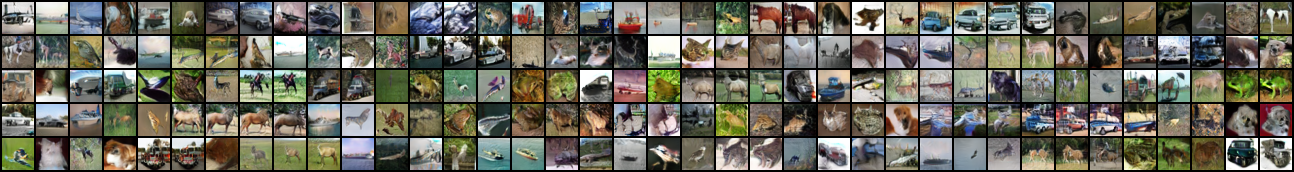

In [ ]:
imgs = []
for step in range(xs.shape[0]):
    img = xs[step]
    imgs.append(img)
imgs = torch.stack(imgs, 1).view(-1, 3, 32, 32)
grid = make_grid(imgs, nrow=xs.shape[0])

grid = (255 * grid.permute(1, 2, 0).numpy()).astype('uint8')
Image.fromarray(grid)